## Engenharia de Features

Aula referente a Semana 7 do Acelera Dev Data Science do Codenation

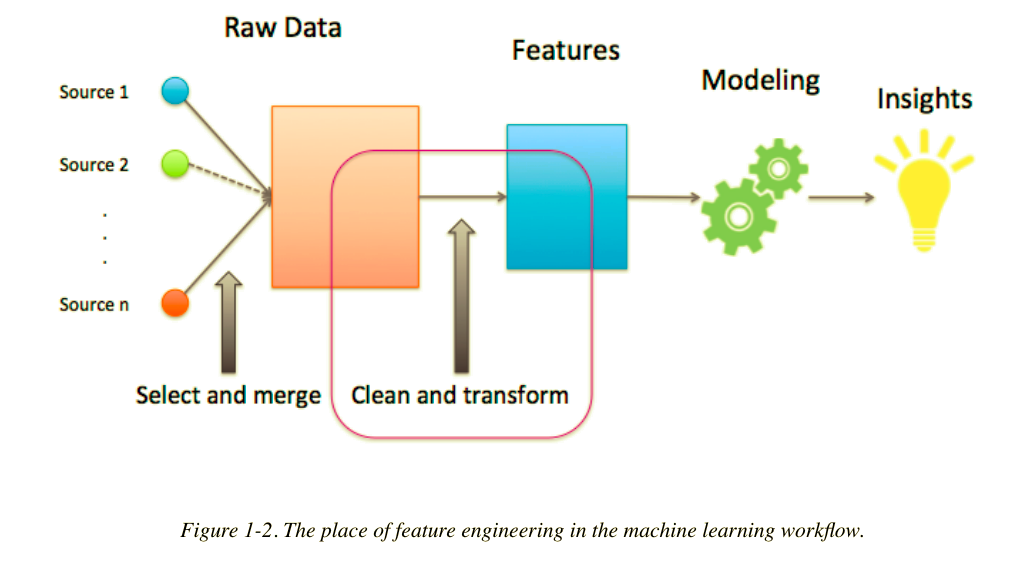

### Importando as Libs

In [2]:
import functools
from math import sqrt

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import scipy.stats as sct
import seaborn as sns
from sklearn.datasets import load_digits, fetch_20newsgroups
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import (
    CountVectorizer, TfidfTransformer, TfidfVectorizer
)
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder, Binarizer, KBinsDiscretizer,
    MinMaxScaler, StandardScaler, PolynomialFeatures
)

In [3]:
# Algumas configurações para o matplotlib.
%matplotlib inline

from IPython.core.pylabtools import figsize


figsize(12, 12)

sns.set()

In [4]:
np.random.seed(1000)

### One-hot enconding

Uma das formas mais simples de representação de variáveis categóricas é através do método chamado **one-hot enconding** . Com ele, uma variável categórica com $h$ categorias é transformada em $h$ novas variáveis binárias (0 ou 1), onde a presença do 1 (hot) significa que aquela observação pertence àquela categoria, e 0 (cold) que não pertence. Veja um exemplo abaixo:

In [5]:
rows = 100

height = np.random.normal(loc=1.70, scale=0.2, size=rows).round(3)
score = np.random.normal(loc=7, scale=1, size=rows).round(2)
courses = ["Math", "Physics", "Biology"]
course = np.random.choice(courses, size=rows)

data = pd.DataFrame({"Height": height, "Score": score, "Course": course})


data.head(10)

,Height,Score,Course
0,1.539,6.61,Biology
1,1.764,6.42,Biology
2,1.695,8.95,Biology
3,1.829,5.14,Biology
4,1.640,6.43,Physics
5,1.778,7.98,Physics
6,1.679,7.90,Biology
7,1.604,6.76,Physics
8,1.819,7.44,Physics
9,1.607,6.01,Physics


Criamos um data set que contém duas variáveis numéricas (Height e Score) e uma variável categórica (Course). 

O objetivo com o one-hot encoding é transformar a variável Course em uma sequência de variáveis numéricas binárias, cada uma descrevendo uma classe da variável. 

Neste caso, como temos três categorias para Course (Biology, Physics e Math), teremos três novas variáveis binárias.

In [6]:
#Treinando o encoder
one_hot_encoder = OneHotEncoder(sparse=False, dtype=np.int)

#one_hot_encoder.fit(data[["Course"]])

#course_encoded = one_hot_encoder.transform(...)

course_encoded = one_hot_encoder.fit_transform(data[["Course"]])

course_encoded[:10]

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

A saída é um np.ndarray com formato (n, h), onde n é o número de observações no data set e h é o número de categorias da variável codificada.

In [7]:
course_encoded.shape

(100, 3)

O atributo *categories* do Encoter contém as categorias da variável curso.

In [8]:
one_hot_encoder.categories_

[array(['Biology', 'Math', 'Physics'], dtype=object)]

Podemos criar as novas colunas que descrevem cada categoria. 

Repare que, para qualquer linha, apenas uma das colunas contém um 1, indicando a qual categoria aquela observação pertence. 

Isso ocorre se as categorias forem mutuamente exclusivas.

In [9]:
columns_encoded = one_hot_encoder.categories_[0]

data_encoded = pd.concat([data, pd.DataFrame(course_encoded, columns=columns_encoded)], axis=1)

data_encoded.head(10)

,Height,Score,Course,Biology,Math,Physics
0,1.539,6.61,Biology,1,0,0
1,1.764,6.42,Biology,1,0,0
2,1.695,8.95,Biology,1,0,0
3,1.829,5.14,Biology,1,0,0
4,1.640,6.43,Physics,0,0,1
5,1.778,7.98,Physics,0,0,1
6,1.679,7.90,Biology,1,0,0
7,1.604,6.76,Physics,0,0,1
8,1.819,7.44,Physics,0,0,1
9,1.607,6.01,Physics,0,0,1


A maior parte da matriz retornada é composta por zeros, sendo apenas alguns elementos compostos de um. 

Essa matriz é **esparsa**. 

É um grande desperdício de memória trabalhar diretamente como uma matriz esparsa assim. Por isso, o default do OneHotEncoder é retornar uma sparse matrix do NumPy, economizando espaço em memória:

In [10]:
one_hot_encoder_sparse = OneHotEncoder(sparse=True) # sparse=True é o default.

course_encoded_sparse = one_hot_encoder_sparse.fit_transform(data[["Course"]])

course_encoded_sparse

<100x3 sparse matrix of type '<class 'numpy.float64'>'
	with 100 stored elements in Compressed Sparse Row format>

In [11]:
#Convertendo a matriz em um array não esparso
course_encoded_sparse.toarray()[:10]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

### Binarização

Binarização é o processo de discretizar uma variável numérica em dois níveis com base em um threshold. 

No exemplo abaixo, vamos separar a variável Height em dois grupos, utilizando 1.80 m como threshold de separação. Observações que possuam menos de 1.80 m terão valor 0, enquanto aquelas com mais de 

In [12]:
tall = (data_encoded.Height > 1.80)

tall[:10]

0    False
1    False
2    False
3     True
4    False
5    False
6    False
7    False
8     True
9    False
Name: Height, dtype: bool

In [13]:
binarizer = Binarizer(threshold=1.80).fit(data_encoded[["Height"]])

height_binary = binarizer.transform(data_encoded[["Height"]])

height_binary[:10]

array([[0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.]])

aída uma matriz binária numérica. Podemos transformá-la em um vetor de bool:

In [14]:
height_bool = pd.DataFrame(height_binary.flatten().astype(bool), columns=["Tall"])

height_bool.head(10)

,Tall
0,False
1,False
2,False
3,True
4,False
5,False
6,False
7,False
8,True
9,False


Adicionando uma nova variável Tall, que indica se a pessoa é alta (> 1.80 m), ao nosso dataset.

In [15]:
data_encoded = pd.concat([data_encoded, height_bool], axis=1)

data_encoded.head(10)

,Height,Score,Course,Biology,Math,Physics,Tall
0,1.539,6.61,Biology,1,0,0,False
1,1.764,6.42,Biology,1,0,0,False
2,1.695,8.95,Biology,1,0,0,False
3,1.829,5.14,Biology,1,0,0,True
4,1.640,6.43,Physics,0,0,1,False
5,1.778,7.98,Physics,0,0,1,False
6,1.679,7.90,Biology,1,0,0,False
7,1.604,6.76,Physics,0,0,1,False
8,1.819,7.44,Physics,0,0,1,True
9,1.607,6.01,Physics,0,0,1,False


### Discretização (*Binning*)

Discretização é o processo de discretizar ou separar em intervalos contínuos uma variável numérica. Isso pode ser útil para converter uma variável numérica em categórica, quando o valor exato numérico não for tão importante quanto o intervalo onde ele se encontra.

Podemos criar bins (buckets ou intervalos) que contenham aproximadamente a mesma quantidade de observações, utilizando a estratégia quantile ou que sejam igualmente espaçados com a estratégia uniform.

No exemplo a seguir, criamos quatro intervalos da variável Score com a estratégia 

In [16]:
discretizer = KBinsDiscretizer(n_bins=4, encode="ordinal", strategy="quantile")

discretizer.fit(data_encoded[["Score"]])

score_bins = discretizer.transform(data_encoded[["Score"]])

score_bins[:10]

array([[1.],
       [1.],
       [3.],
       [0.],
       [1.],
       [3.],
       [3.],
       [2.],
       [2.],
       [0.]])

Os limites dos intervalos estão disponíveis no atributo bin_edges_. Isso pode ser útil para criarmos labels para colunas do data set por exemplo:

In [17]:
discretizer.bin_edges_

array([array([4.09  , 6.1975, 6.735 , 7.6   , 9.28  ])], dtype=object)

A função get_interval() abaixo facilita a criação de labels indicativas dos intervalos:

In [18]:
def get_interval(bin_idx, bin_edges):
  return f"{np.round(bin_edges[bin_idx], 2):.2f} ⊢ {np.round(bin_edges[bin_idx+1], 2):.2f}"

Cada um dos intervalos mostrados abaixo deve possuir aproximadamente a mesma quantidade de observações:

In [19]:
bin_edges_quantile = discretizer.bin_edges_[0]

print(f"Bins quantile")
print(f"interval: #elements\n")
for i in range(len(discretizer.bin_edges_[0])-1):
    print(f"{get_interval(i, bin_edges_quantile)}: {sum(score_bins[:, 0] == i)}")

Bins quantile
interval: #elements

4.09 ⊢ 6.20: 25
6.20 ⊢ 6.74: 25
6.74 ⊢ 7.60: 25
7.60 ⊢ 9.28: 25


A Series abaixo mostra alguns dos intervalos para os quais as observações foram encaixadas:

In [20]:
score_intervals = pd.Series(score_bins.flatten().astype(np.int)).apply(get_interval, args=(bin_edges_quantile,))

score_intervals.head(10)

0    6.20 ⊢ 6.74
1    6.20 ⊢ 6.74
2    7.60 ⊢ 9.28
3    4.09 ⊢ 6.20
4    6.20 ⊢ 6.74
5    7.60 ⊢ 9.28
6    7.60 ⊢ 9.28
7    6.74 ⊢ 7.60
8    6.74 ⊢ 7.60
9    4.09 ⊢ 6.20
dtype: object

In [21]:
data_encoded = pd.concat([data_encoded, pd.DataFrame(score_intervals, columns=["Score_interval"])], axis=1)

data_encoded.head(10)


,Height,Score,Course,Biology,Math,Physics,Tall,Score_interval
0,1.539,6.61,Biology,1,0,0,False,6.20 ⊢ 6.74
1,1.764,6.42,Biology,1,0,0,False,6.20 ⊢ 6.74
2,1.695,8.95,Biology,1,0,0,False,7.60 ⊢ 9.28
3,1.829,5.14,Biology,1,0,0,True,4.09 ⊢ 6.20
4,1.640,6.43,Physics,0,0,1,False,6.20 ⊢ 6.74
5,1.778,7.98,Physics,0,0,1,False,7.60 ⊢ 9.28
6,1.679,7.90,Biology,1,0,0,False,7.60 ⊢ 9.28
7,1.604,6.76,Physics,0,0,1,False,6.74 ⊢ 7.60
8,1.819,7.44,Physics,0,0,1,True,6.74 ⊢ 7.60
9,1.607,6.01,Physics,0,0,1,False,4.09 ⊢ 6.20


Utilizamos encode=onehot-dense para informar que queremos que a saída seja codificada como o one-hot encode visto anteriormente:

In [22]:
discretizer_uniform = KBinsDiscretizer(n_bins=4, encode="onehot-dense", strategy="uniform")

discretizer_uniform.fit(data_encoded[["Score"]])

score_bins_uniform = discretizer_uniform.transform(data_encoded[["Score"]]).astype(np.int)

score_bins_uniform[:10]

array([[0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0]])

In [23]:
bin_edges_uniform = discretizer_uniform.bin_edges_[0]

bin_edges_uniform

array([4.09  , 5.3875, 6.685 , 7.9825, 9.28  ])

In [24]:
score_intervals_columns = [get_interval(i, bin_edges_uniform) for i in range(4)]

print(f"Bins uniform")
print(f"interval: #elements\n")
for i in range(len(discretizer_uniform.bin_edges_[0])-1):
    print(f"{get_interval(i, bin_edges_uniform)}: {sum(score_bins_uniform[:, i])}")

Bins uniform
interval: #elements

4.09 ⊢ 5.39: 6
5.39 ⊢ 6.68: 43
6.68 ⊢ 7.98: 44
7.98 ⊢ 9.28: 7


In [25]:
data_encoded = pd.concat([data_encoded, pd.DataFrame(score_bins_uniform, columns=score_intervals_columns)], axis=1)

data_encoded.head(10)

,Height,Score,Course,Biology,Math,Physics,Tall,Score_interval,4.09 ⊢ 5.39,5.39 ⊢ 6.68,6.68 ⊢ 7.98,7.98 ⊢ 9.28
0,1.539,6.61,Biology,1,0,0,False,6.20 ⊢ 6.74,0,1,0,0
1,1.764,6.42,Biology,1,0,0,False,6.20 ⊢ 6.74,0,1,0,0
2,1.695,8.95,Biology,1,0,0,False,7.60 ⊢ 9.28,0,0,0,1
3,1.829,5.14,Biology,1,0,0,True,4.09 ⊢ 6.20,1,0,0,0
4,1.640,6.43,Physics,0,0,1,False,6.20 ⊢ 6.74,0,1,0,0
5,1.778,7.98,Physics,0,0,1,False,7.60 ⊢ 9.28,0,0,1,0
6,1.679,7.90,Biology,1,0,0,False,7.60 ⊢ 9.28,0,0,1,0
7,1.604,6.76,Physics,0,0,1,False,6.74 ⊢ 7.60,0,0,1,0
8,1.819,7.44,Physics,0,0,1,True,6.74 ⊢ 7.60,0,0,1,0
9,1.607,6.01,Physics,0,0,1,False,4.09 ⊢ 6.20,0,1,0,0
